In [1]:
%matplotlib inline
import json
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from statsmodels.nonparametric.kernel_regression import KernelReg

import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager

from scipy.stats import gaussian_kde

In [2]:
# Set your directories accordingly
# Please adjust the following paths as needed
data_dir = "/mnt/hdd1/chenyang/benchmark_data/matrix_resource/data-all" 
# mat_dir = "/u/3/yibo/exp-result/0808-old/solver-mat" # mat data
mat_dir = "/mnt/hdd1/chenyang/benchmark_data/matrix_resource/solver-mat-0906"
result_dir = "/u/1/chenyang/benchmark_data/exp-result-yibo/20250617"  # experiment metrics apart from mat
save_dir = "/u/1/chenyang/benchmark/analysis/output_test"
# solver_list = ["Pardiso", "Trilinos", "Trilinos-nullspace", "AMGCL", "Hypre"]
# solver_list = ["Pardiso", "AMGCL", "Hypre"]
solver_list = ["Hypre", "AMGCL", "Eigen::PardisoLDLT"]

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# solver_list = [solver_list[2]]
# print(solver_list)

### Extract data

In [3]:
def get_mat_sz(fp):
    try:
        # the first 8 values are: dim, is_spd, is_sequence, nrow, ncol, nnz, outer_sz, inner_sz
        # nnz, number of non-zero element
        meta = np.fromfile(fp, dtype=np.int32, count=8, offset=0)
        n_rows = meta[3]
        return n_rows
    except:
        print("mat size exception")
        return None

def get_nnz(fp):
    try:
        meta = np.fromfile(fp, dtype=np.int32, count=8, offset=0)
        nnz = meta[5]
        return nnz
    except:
        print("nnz exception")
        return None

def get_density(nnz, mat_sz):
    if nnz is None or mat_sz is None:
        return None
    else:
        nnz =  np.float128(nnz)
        mat_sz =  np.float128(mat_sz)
        return (nnz + 1e-10) / (mat_sz * mat_sz + 1e-10)

def get_sparsity(nnz, mat_sz):
    if nnz is None or mat_sz is None:
        return None
    else:
        nnz =  np.float128(nnz)
        mat_sz =  np.float128(mat_sz)
        return (mat_sz * mat_sz - nnz) / (mat_sz * mat_sz)

def extract_data(fname):
    if not os.path.exists(fname):
        return None
    time_li = []
    mem_li = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            time = float(line.split(" ")[4])
            mem = float(line.split(" ")[5])
            time_li.append(time)
            mem_li.append(mem)
    if len(time_li) == 0:
        return None
    time_avg = sum(time_li) / len(time_li)
    mem_avg = sum(mem_li) / len(mem_li)
    return {"time": time_avg, "mem": mem_avg}    

def extract_data_trilinos(fname):
    if not os.path.exists(fname):
        return None
    time_li = []
    mem_li = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "[BOS]" in line:
                time = float(line.split(" ")[0].strip("[BOS]").strip("[EOS]"))
                mem = float(line.split(" ")[1])
                time_li.append(time)
                mem_li.append(mem)
    if len(time_li) == 0:
        return None
    time_avg = sum(time_li) / len(time_li)
    mem_avg = sum(mem_li) / len(mem_li)
    return {"time": time_avg, "mem": mem_avg}


In [4]:
def sequence_data(fname):
    if not os.path.exists(fname):
        print(fname)
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            try:
                time = float(line.split(" ")[4])
                mem = float(line.split(" ")[5])
                seq.append([time, mem])
            except:
                seq.append([-1, -1])
                continue
    if len(seq) == 0:
        return None
    return seq

def sequence_data_trillinos(fname):
    if not os.path.exists(fname):
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "[BOS]" in line:
                time = float(line.split(" ")[0].strip("[BOS]").strip("[EOS]"))
                mem = float(line.split(" ")[1])
                seq.append([time, mem])
            elif "Aborted (core dumped)" in line:
                seq.append([-1, -1])

    if len(seq) == 0:
        return None
    return seq

def sequence_data_hypre(fname):
    if not os.path.exists(fname):
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "hypre error" in line:
                seq.append([-1, -1])
                continue
            if "hypre" not in line:
                try:
                    time = float(line.split(" ")[4])
                    mem = float(line.split(" ")[5])
                    seq.append([time, mem])
                except:
                    continue

    if len(seq) == 0:
        return None
    return seq

def check_bin_log(bin_path, log_file):
    start_i = 1
    start_j = 1
    end_i = 10000
    end_j = 10000

    
#     if os.path.exists(log_file):
#         with open(log_file,"r")as f:
#             last_line=f.readlines()[-1]
#             last_i=int(last_line.split(" ")[1])
#             last_j=int(last_line.split(" ")[2])
#         start_i=last_i+1
#         start_j=last_j+1
    
    search_i = 1
    while(search_i < 10000):
        if os.path.exists(os.path.join(bin_path,"%d_%d_A.bin"%(search_i,1))):
            break
        search_i += 1

    start_i = search_i

    seq = []    
    i = start_i
    j = start_j
    fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
    fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
    
    while(os.path.exists(fp_a) and i < end_i):
        while(os.path.exists(fp_a) and j < end_j):
#     while(i < end_i):
#         while(j < end_j):
            if (os.path.exists(fp_a)):
                seq.append([i,j,fp_a, fp_b])
            j += 1
            fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
            fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
        j = start_j
        i += 1
        fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
        fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
        
        
    return seq


In [5]:
with open(os.path.join(data_dir, "filenames.json"), "r") as f:
    filenames = json.load(f)
    prenames = filenames["prenames"] # experiment name
    fpaths = filenames["fpaths"] # corresponding json file

    data_all = []
#     for solver in solver_list:
#         data_all[solver] = []

    for fpath, prename in zip(fpaths, prenames):
        
        for solver in solver_list:           
            fp = "%s/%s/%s.log" % (result_dir, solver, prename)
            if solver == "Trilinos" or solver == "Trilinos-nullspace":
                seq_data = sequence_data_trillinos(fp)
            elif solver == "Hypre":
                seq_data = sequence_data_hypre(fp)
            else:
                seq_data = sequence_data(fp)

            if seq_data == None:
                print("no log for this prename: ", prename, solver)
                break
#             print("seq_data lens: ", len(seq_data), "prename: ",prename )
            
            bin_path = os.path.join(mat_dir, prename)
            bin_logged = check_bin_log(bin_path, fp)
#             print("bin_logged lens: ", len(bin_logged), "prename: ",prename )

            if len(seq_data) != len(bin_logged):
                print(solver, prename, "lens mismatching", "seq_data: ", len(seq_data), " bin_logged: ", len(bin_logged))
                print(bin_path)
#                 break
#             else:
#                 print(solver, prename, "lens matching", "seq_data: ", len(seq_data), " bin_logged: ", len(bin_logged))
                
            for [time, mem], bin_file in zip(seq_data , bin_logged):
                single_trial = {}
                single_trial["fpath"] = fpath
                single_trial["prename"] = prename
                single_trial["outer_i"] = bin_file[0]
                single_trial["inner_j"] = bin_file[1]
                single_trial["solver"] = solver
                single_trial["time"] = time * 1000 #unit mili seconds
                single_trial["mem"] = mem
                single_trial["mat_sz"] = get_mat_sz(bin_file[2])
                single_trial["nnz"] = get_nnz(bin_file[2])
                single_trial["density"] = get_density(single_trial["nnz"], single_trial["mat_sz"])
                single_trial["sparsity"] = get_sparsity(single_trial["nnz"], single_trial["mat_sz"])
                data_all.append(single_trial)
                
#         for solver in solver_list:           
#             fp = "%s/%s/%s.log" % (result_dir, solver, prename)
#             if solver == "Trilinos" or solver == "Trilinos-nullspace":
#                 avg_data = extract_data_trilinos(fp)
#             elif solver == "Hypre":
#                 avg_data = extract_data_hypre(fp)
#             else:
#                 avg_data = extract_data(fp)
#             avg_data = extract_data(fp)
#             if avg_data is None:
#                 avg_data = {'time': 0.0, 'mem': 0.0}
#             avg_data["fpath"] = fpath
#             avg_data["prename"] = prename
#             avg_data["time"] = avg_data["time"] * 1000  # convert sec to ms
#             avg_data["mat_sz"] = get_mat_sz(os.path.join(mat_dir, prename, "1_1_A.bin"))
#             print(os.path.join(mat_dir, prename, "1_1_A.bin"))
#             avg_data["nnz"] = get_nnz(os.path.join(mat_dir, prename, "1_1_A.bin"))
#             avg_data["density"] = get_density(avg_data["nnz"], avg_data["mat_sz"])
#             avg_data["sparsity"] = get_sparsity(avg_data["nnz"], avg_data["mat_sz"])
#             data_all[solver].append(avg_data)

    columns = ["fpath",     
               "prename", 
               "outer_i",
               "inner_j",
               "solver",
               "time",
               "mem",
               "mat_sz",
               "nnz",
               "density",
               "sparsity"]

    writer = pd.ExcelWriter(os.path.join(save_dir, 'profiling.xlsx'))
#     for solver in solver_list:
#         df0 = pd.DataFrame(data_all[solver], columns=columns)
#         df0.to_excel(writer, sheet_name=solver)
    df_all = pd.DataFrame(data_all, columns=columns)
    
    columns_log = [
       "time",
       "mem",
       "mat_sz",
       "nnz",
       "density",
       "sparsity"]

    mask = (df_all[columns_log] > 0).all(axis=1)
    df_all_clean = df_all[mask].copy()
    
    for col in columns_log:
        df_all[col + "_log"] = np.log10(df_all_clean[col] + 1e-10)  # 防止 log(0)
#         df_all[col + "_log"] = np.log10(df_all[col].clip(lower=1e-10))
        
    print(df_all[[col + "_log" for col in columns_log]].head())    
    
    df_all.to_excel(writer)
    writer.close()

#     return data_all

no log for this prename:  friction-slope Hypre
AMGCL 3D-card-house lens mismatching seq_data:  798  bin_logged:  888
/mnt/hdd1/chenyang/benchmark_data/matrix_resource/solver-mat-0906/3D-card-house
no log for this prename:  kick Hypre
Hypre sphere-mat lens mismatching seq_data:  807  bin_logged:  809
/mnt/hdd1/chenyang/benchmark_data/matrix_resource/solver-mat-0906/sphere-mat
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz excep

### Plot data, time vs mat_size

In [6]:
print(len(df_all))
# print(df_all.iloc[0])

144385


In [7]:
df_now = df_all.copy()
matrix_size_list = df_now["mat_sz"].unique()
print(matrix_size_list)
print(sorted(matrix_size_list))


# filtered_df = df_now[df_now["mat_sz"] == 10462]
filtered_df = df_now[df_now["mat_sz"] == 131817]


filtered_df = filtered_df[filtered_df["time"]>0]

min_time_row = filtered_df.loc[filtered_df["time"].idxmin()]

max_time_row = filtered_df.loc[filtered_df["time"].idxmax()]

# Show results
print("Row with smallest time:\n", min_time_row)
print(min_time_row["fpath"])
print(min_time_row["time"])
print("\nRow with largest time:\n", max_time_row)
print(max_time_row["fpath"])
print(max_time_row["time"])


print(filtered_df["prename"].unique())
df_solver_select = df_now[df_now["prename"] == 'golf-ball-doformable-wall']
print(df_solver_select["mat_sz"].unique() )

[8.00000e+00 1.04620e+04 9.66600e+03 1.60000e+01 2.48000e+03 2.55200e+03
 2.00000e+02 6.04000e+02 6.54000e+02 2.38800e+03 2.87200e+03 6.00000e+00
 4.00000e+01 2.00000e+00 8.64990e+04 1.39230e+04 2.40000e+01 6.00000e+02
 1.68480e+04 1.96161e+05 2.11020e+04 2.29380e+04 3.48210e+04 5.28000e+03
 5.19600e+03 9.60000e+03 1.92000e+04 4.80000e+01 1.44000e+04         nan
 4.47840e+04 4.47120e+04 9.12000e+03 2.51970e+04 2.41410e+04 1.31817e+05
 7.18800e+03 1.20000e+01 1.20000e+02 1.83600e+03 1.50000e+01 3.00000e+00
 1.80000e+01 7.80000e+01 7.50000e+01 1.38000e+02 2.25360e+04 2.10240e+04
 1.87140e+04]
[2.0, 3.0, 6.0, 8.0, 12.0, 15.0, 16.0, 18.0, 24.0, 40.0, 48.0, 75.0, 78.0, 120.0, 138.0, 200.0, 600.0, 604.0, 654.0, 1836.0, 2388.0, 2480.0, 2552.0, 2872.0, 5196.0, 5280.0, 7188.0, 9120.0, 9600.0, 9666.0, 10462.0, 13923.0, 14400.0, 16848.0, 18714.0, 19200.0, 21024.0, 21102.0, 22536.0, 22938.0, 24141.0, 25197.0, 34821.0, 44712.0, 44784.0, 86499.0, 131817.0, 196161.0, nan]
Row with smallest time:
 fpa

In [8]:
New_data = [["AMGCL", 327843, 15128], 
            ["AMGCL", 327843, 15822],
            ["AMGCL", 327843, 11839],
            ["AMGCL", 327843, 14196],
            ["AMGCL", 327843, 10936],
            ["AMGCL", 327843, 11617],
            ["AMGCL", 327843, 14482],
            ["AMGCL", 327843, 12419],
            ["AMGCL", 327843, 14482],
            ["AMGCL", 327843, 12419],
            ["AMGCL", 327843, 14175],
            ["AMGCL", 327843, 14573],
            ["AMGCL", 327843, 22361],
            ["AMGCL", 327843, 26976],
            ["AMGCL", 327843, 21830],
            ["AMGCL", 327843, 16996],
            ["AMGCL", 327843, 11451],
            ["AMGCL", 327843, 12119],
            
            ["Hypre", 327843, 12419],
            ["Hypre", 327843, 18426], 
            ["Hypre", 327843, 20911], 
            ["Hypre", 327843, 6366], 
            ["Hypre", 327843, 10079], 
            ["Hypre", 327843, 6321],
            ["Hypre", 327843, 5208],
            ["Hypre", 327843, 6991],
            ["Hypre", 327843, 17426],
            ["Hypre", 327843, 10295],
            ["Hypre", 327843, 7546],
            ["Hypre", 327843, 22606],
            ["Hypre", 327843, 22421],
            ["Hypre", 327843, 18626],
            ["Hypre", 327843, 15238],
            ["Hypre", 327843, 3970],
            
            ["Eigen::PardisoLDLT", 327843, 173783],
            ["Eigen::PardisoLDLT", 327843, 172593],
            ["Eigen::PardisoLDLT", 327843, 161968],
            ["Eigen::PardisoLDLT", 327843, 229867],
            ["Eigen::PardisoLDLT", 327843, 173783],
            ["Eigen::PardisoLDLT", 327843, 184672],
            ["Eigen::PardisoLDLT", 327843, 172598],
            ["Eigen::PardisoLDLT", 327843, 182732],
            ["Eigen::PardisoLDLT", 327843, 175662],
            ["Eigen::PardisoLDLT", 327843, 203983],
            ["Eigen::PardisoLDLT", 327843, 235975],
            ["Eigen::PardisoLDLT", 327843, 198282],
            ["Eigen::PardisoLDLT", 327843, 227971],
            ["Eigen::PardisoLDLT", 327843, 164957],
            ["Eigen::PardisoLDLT", 327843, 175276],
            ["Eigen::PardisoLDLT", 327843, 220751]
           ]


# Convert to DataFrame
df_new_0 = pd.DataFrame(New_data, columns=["solver", "mat_sz", "time"])
df_new_0["mat_sz_log"] = np.log10(df_new_0["mat_sz"])
df_new_0["time_log"] = np.log10(df_new_0["time"])


Use the exp 'golf-ball-doformable-wall' to discover what factors that influence the time.

Read New Data

In [9]:
def sequence_data_new(fname, solver):
    begin_line = []
    end_line = []
    with open(fname, 'r') as f:
        lines = f.readlines()  # read all lines into a list

    for i, line in enumerate(lines):
        if "[EXPBEGIN]" in line:
            begin_line.append(i)
        if "[EXPEND]" in line:
            end_line.append(i)

    len_begin = len(begin_line)
    len_end = len(end_line)
    if len_begin != len_end:
        print("#[EXPBEGIN] #[EXPEND] mismatches, unknown error formats.")

    begin_correct = []
    end_correct = []

    for begin_i, end_i in zip(begin_line, end_line):
        error_detected = False
        for j in range(begin_i, end_i):
            if "ERROR" in lines[j] or "error" in lines[j]:
#                 print(f"errors between {begin_i+1} line and {end_i+1} line")
                error_detected = True
                break
        if error_detected:
            continue 
        begin_correct.append(begin_i)
        end_correct.append(end_i)
    if error_detected:
        print("error in current exp: ", fname)


    seq = []
    for begin_i, end_i in zip(begin_correct, end_correct):
        element = {}
        if solver == "Eigen::PardisoLDLT":
            element["solver"] = lines[begin_i-3].split(" ")[3].strip()
            element["bin_file_A"] = lines[begin_i-3].split(" ")[1]
            element["bin_file_B"] = lines[begin_i-3].split(" ")[2]
            element["memory_usage_mb"] = float(lines[begin_i-1].split(" ")[-1].strip())
            element["outer_i"] = float(lines[end_i-4].split(" ")[-1].strip())
            element["inner_i"] = float(lines[end_i-3].split(" ")[-1].strip())
            element["clock_time"] = float(lines[end_i-2].split(" ")[-1].strip().rstrip("s"))
            element["elapse_time"] = float(lines[end_i-1].split(" ")[-1].strip().rstrip("s"))   
            
        else:
            element["solver"] = lines[begin_i-3].split(" ")[3].strip()
            element["bin_file_A"] = lines[begin_i-3].split(" ")[1]
            element["bin_file_B"] = lines[begin_i-3].split(" ")[2]
            element["memory_usage_mb"] = float(lines[begin_i-1].split(" ")[-1].strip())
            element["outer_i"] = float(lines[end_i-9].split(" ")[-1].strip())
            element["inner_i"] = float(lines[end_i-8].split(" ")[-1].strip())
            element["solver_tol"] = float(lines[end_i-7].split(" ")[-1].strip())
            element["solver_maxiter"] = float(lines[end_i-6].split(" ")[-1].strip())
            element["final_res_norm"] = float(lines[end_i-5].split(" ")[-1].strip())
            element["num_iterations"] = float(lines[end_i-4].split(" ")[-1].strip())
            element["norm_b"] = float(lines[end_i-3].split(" ")[-1].strip())
            element["clock_time"] = float(lines[end_i-2].split(" ")[-1].strip().rstrip("s"))
            element["elapse_time"] = float(lines[end_i-1].split(" ")[-1].strip().rstrip("s"))

            if solver == "AMGCL":
                element["factorize"] = float(lines[end_i-11].split(" ")[-1].strip().rstrip("s"))
                element["solve"] = float(lines[end_i-10].split(" ")[-1].strip().rstrip("s"))
        seq.append(element)
    return seq

In [10]:
new_data_dir = "/u/1/chenyang/benchmark_data/larger_matrix_exp/larger_mat_exp_result/trial_1"

# new_data = sequence_data_new("/u/1/chenyang/benchmark_data/larger_matrix_exp/larger_mat_exp_result/AMGCL_3D_golf_ball_109281.log","AMGCL")
# print(new_data[0])

In [14]:
df_new = []
log_lists= [
        os.path.join(new_data_dir, fname)
        for fname in os.listdir(new_data_dir)
        if fname.lower().endswith('.log')
        and os.path.isfile(os.path.join(new_data_dir, fname))
    ]

for log_file in log_lists:
    solver = log_file.split("/")[-1].split("_")[0]
    print("solver")
    new_data_seq = sequence_data_new(log_file , solver)
    
    for new_data_element in new_data_seq:
        new_log = {}
        new_log["solver"] = new_data_element["solver"]
        new_log["mat_sz"] = get_mat_sz(new_data_element["bin_file_A"])
        new_log["time"] = new_data_element["elapse_time"]*1000
        new_log["mem"] = new_data_element["memory_usage_mb"]
        df_new.append(new_log)

print(df_new[0])
        
df_new = pd.DataFrame(df_new)
df_new["mat_sz_log"] = np.log10(df_new["mat_sz"])
df_new["time_log"] = np.log10(df_new["time"])


solver
solver
solver
solver
solver
solver
{'solver': 'Hypre', 'mat_sz': 118128, 'time': 4767.8, 'mem': 10.850651}


### Time vs mat size, all solver

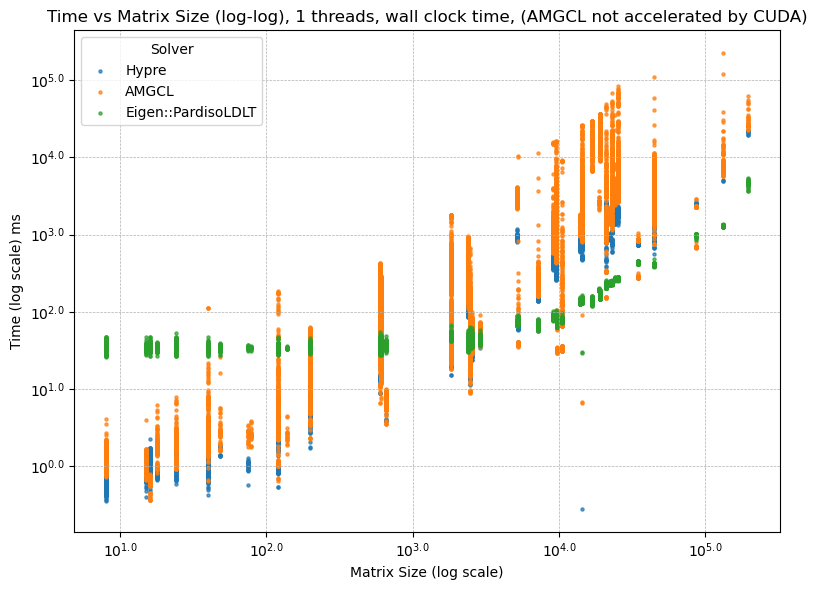

In [15]:
df_now = df_all.copy()
# df_filtered = df_now[df_now["mat_sz"] >= 100].copy()
# df_now["mat_sz_log_rounded"] = df_filtered["mat_sz_log"].round(1)


colors = plt.cm.tab10.colors  # 或者 plt.cm.Set1, plt.cm.Paired 等等
solvers = df_now["solver"].unique()


def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))

for i, solver in enumerate(solvers):
    group = df_now[df_now["solver"] == solver]
    plt.scatter(
        group["mat_sz_log"], group["time_log"],
        alpha=0.7, s=5,
        color=colors[i % len(colors)],
        label=solver
    )
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale) ms")
plt.title("Time vs Matrix Size (log-log), 1 threads, wall clock time, (AMGCL not accelerated by CUDA)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(title="Solver")
plt.tight_layout()
plt.show()


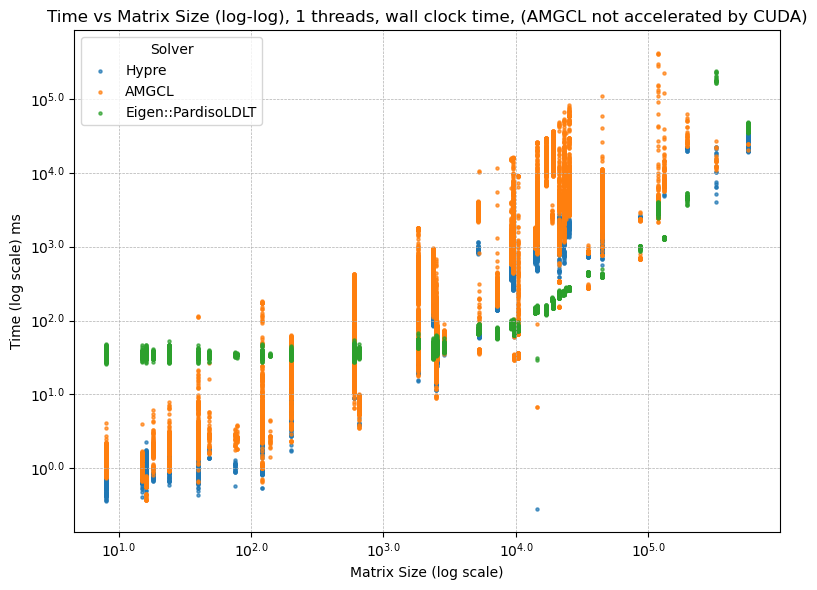

In [16]:
# Append to df_now
df_now_with_new = pd.concat([df_all, df_new, df_new_0], ignore_index=True)

df_now = df_now_with_new.copy()
# df_filtered = df_now[df_now["mat_sz"] >= 100].copy()
# df_now["mat_sz_log_rounded"] = df_filtered["mat_sz_log"].round(1)


colors = plt.cm.tab10.colors  # 或者 plt.cm.Set1, plt.cm.Paired 等等


def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))

for i, solver in enumerate(solvers):
    group = df_now[df_now["solver"] == solver]
    plt.scatter(
        group["mat_sz_log"], group["time_log"],
        alpha=0.7, s=5,
        color=colors[i % len(colors)],
        label=solver
    )
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale) ms")
plt.title("Time vs Matrix Size (log-log), 1 threads, wall clock time, (AMGCL not accelerated by CUDA)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(title="Solver")
plt.tight_layout()
plt.show()


In [22]:
print("The largest matrix has size of: ", df_new["mat_sz"].unique().max())
print("Memory usage up to: ", df_new["mem"].max(), "mb")

The largest matrix has size of:  567270
Memory usage up to:  10.850651 mb


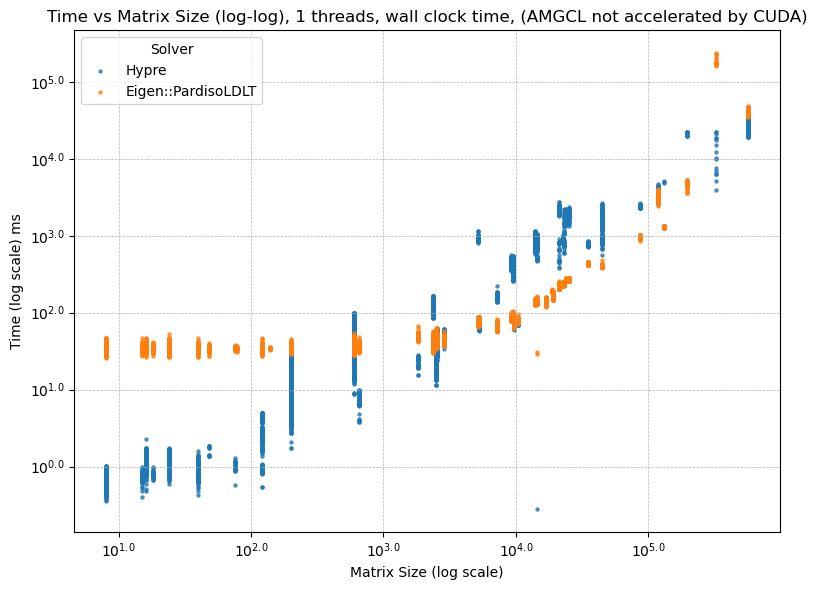

In [24]:
# Append to df_now
df_now_with_new = pd.concat([df_all, df_new, df_new_0], ignore_index=True)

df_now = df_now_with_new.copy()
# df_filtered = df_now[df_now["mat_sz"] >= 100].copy()
# df_now["mat_sz_log_rounded"] = df_filtered["mat_sz_log"].round(1)


colors = plt.cm.tab10.colors  # 或者 plt.cm.Set1, plt.cm.Paired 等等
solvers = df_now["solver"].unique()
solvers = ['Hypre','Eigen::PardisoLDLT']



def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))

for i, solver in enumerate(solvers):
    group = df_now[df_now["solver"] == solver]
    plt.scatter(
        group["mat_sz_log"], group["time_log"],
        alpha=0.7, s=5,
        color=colors[i % len(colors)],
        label=solver
    )
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale) ms")
plt.title("Time vs Matrix Size (log-log), 1 threads, wall clock time, (AMGCL not accelerated by CUDA)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(title="Solver")
plt.tight_layout()
plt.show()
